# 示例代码

首先是一个shapefile有多个polygon组成，每个polygon代表一个流域，拆分成多个shapefile。

examples_data/bas_nonref_CntlPlains.shp
<class 'geopandas.geodataframe.GeoDataFrame'>
           AREA  PERIMETER   GAGE_ID  \
0  1.209580e+08    81060.0  03144816   
1  3.458990e+08   158340.0  03145000   
2  2.573460e+07    38760.0  03156000   
3  2.288740e+08   115800.0  03157000   
4  1.194710e+09   290820.0  03157500   

                                            geometry  
0  POLYGON ((1123005.000 1972005.000, 1123035.000...  
1  POLYGON ((1123005.000 1972005.000, 1123035.000...  
2  POLYGON ((1130325.000 1933275.000, 1130325.000...  
3  POLYGON ((1123755.000 1919955.000, 1123725.000...  
4  POLYGON ((1123755.000 1919955.000, 1123725.000...  
Index(['AREA', 'PERIMETER', 'GAGE_ID', 'geometry'], dtype='object')


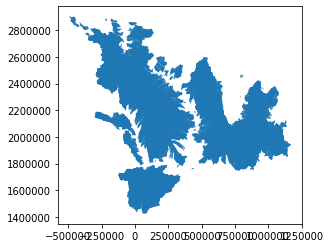

In [3]:
import os
import geopandas as gpd

# Define path to folder，以r开头表示相对路径
input_folder = r"examples_data"

# Join folder path and filename
fp = os.path.join(input_folder, "bas_nonref_CntlPlains.shp")

# Print out the full file path
print(fp)

# Read file using gpd.read_file()
data = gpd.read_file(fp)

print(type(data))
# 注意观察，geometry是一个由一系列坐标点组成的list，放入polygon的
print(data.head())
print(data.columns)

%matplotlib inline
data.plot()

先做坐标转换，首先看看现有数据的坐标系是什么，从上面的数据可以看出，坐标应该是m的形式，肯定是个投影坐标系。

In [4]:
from pyproj import CRS
print(data.crs)
crs_proj4 = CRS(data.crs).to_proj4()
print(crs_proj4)

{'init': 'epsg:5070'}
+proj=aea +lat_0=23 +lon_0=-96 +lat_1=29.5 +lat_2=45.5 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs


epsg:5070代表什么呢？在[epsg网站](https://epsg.io/)上查询，或直接谷歌或百度搜索。经查，在 https://epsg.io/5070-1252 网页上有说明，那现在想把它转为什么坐标呢，想转为下面要用的netcdf数据的坐标，因此这里暂停下，去下面看看netcdf数据的读取。然后查看下netcdf数据的坐标信息，这里先用一个[nad83下的Lambert等角圆锥投影](https://epsg.io/102009)到一个[wgs84下的横轴墨卡托投影](https://epsg.io/41001)的坐标变换做例子，为了验证是否正确，在https://epsg.io/ 网站上转一个点，然后和这里对照。

![](trans_coord.png)

In [5]:
from pyproj import Transformer
from pyproj import Proj, transform
import time

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
crs_to=CRS.from_proj4('+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_from)
print(crs_to)
# print(crs_to.to_epsg())
# 定义transformer
transformer = Transformer.from_crs(crs_from, crs_to, always_xy=True)
x_coord = 1427469.56401013
y_coord = 231871.42687957
start=time.time()
x1,y1 = transformer.transform(x_coord, y_coord)  
end=time.time()
print(x1)
print(y1)
print('%.7f' % (end-start))

#  接着转换x，y坐标为经纬度坐标 WGS84坐标
outProj = Proj(init='epsg:4326')
print(outProj)
x2,y2 = transform(crs_to,outProj,x1,y1)
print(x2)
print(y2)

+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs +type=crs
+proj=merc +lon_0=0 +k=1 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
-8667612.35367563
4954170.578414323
0.0015910
Proj('+proj=longlat +datum=WGS84 +no_defs', preserve_units=True)
-77.86248654129997
40.794609791599655


![](trans_coord1.png)

下面例子中netcdf数据的坐标proj4信息是：+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs

因此，将shapefile文件的坐标转换到该坐标下即可继续后面的运算。先尝试下转换到该坐标系下的情况，然后再转到WGS84下看看对错。坐标是一样的，应该是对的

In [14]:
crs_final=CRS.from_proj4('+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs')
print(crs_final)
# 这应该是自定义的一种投影，没有epsg编号
print(crs_final.to_epsg())
transformer1 = Transformer.from_crs(crs_from, crs_final, always_xy=True)
x3,y3 = transformer1.transform(x_coord, y_coord)  
print(x3)
print(y3)
lon,lat = transform(crs_final,outProj,x3,y3)
print(lon)
print(lat)

# 再试一些点
x4= -4560250
y4= 4984000                         # 3090000
lon4,lat4 = transform(crs_final,outProj,x4,y4)
print(lon4,lat4)
x5= -4560250                 # 3252750
y5=  4983000                # 4984000
lon5,lat5 = transform(crs_final,outProj,x5,y5)
print(lon5,lat5)

+proj=lcc +lat_1=25 +lat_2=60 +lat_0=42.5 +lon_0=-100 +x_0=0 +y_0=0 +datum=WGS84 +units=m +no_defs +type=crs
None
1762267.535784329
54546.4057676215
-77.86248654129997
40.79460979159966
156.37123798357752 58.527701348497665
156.38762505680887 58.52477921360861


再从经纬度转回投影坐标

In [10]:
y,x = transform(outProj,crs_final, lon,lat)
print(y,x)

1762267.5357843342 54546.40576760309


如果是shapefile，那么直接一个个地转换坐标是很慢的，所以看看能不能直接转换shapefile，找到了一个利用pandas dataframe的算法。以下代码参考：https://gis.stackexchange.com/a/327367/154364

In [25]:
import pandas as pd
from pyproj import Proj, transform
from pyproj import Transformer
import time

crs_from=CRS.from_proj4('+proj=lcc +lat_1=20 +lat_2=60 +lat_0=40 +lon_0=-96 +x_0=0 +y_0=0 +datum=NAD83 +units=m +no_defs')
outProj = Proj(init='epsg:4326')
df = pd.DataFrame({'x': [1427469.56401013]*100000, 
                   'y': [231871.42687957]*100000})
print(type(df['x']))
start=time.time()
df['x2'], df['y2'] = transform(crs_from, outProj, df['x'].tolist(), df['y'].tolist())
end=time.time()
print('%.7f' % (end-start))
print(df['x2'])
print(df['y2'])

<class 'pandas.core.series.Series'>
0.2420700
0       -77.862487
1       -77.862487
2       -77.862487
3       -77.862487
4       -77.862487
           ...    
99995   -77.862487
99996   -77.862487
99997   -77.862487
99998   -77.862487
99999   -77.862487
Name: x2, Length: 100000, dtype: float64
0        40.79461
1        40.79461
2        40.79461
3        40.79461
4        40.79461
           ...   
99995    40.79461
99996    40.79461
99997    40.79461
99998    40.79461
99999    40.79461
Name: y2, Length: 100000, dtype: float64


接下来就构建一个shapefile到shapefile的代码，首先读取shapefile，然后对每个polygon的每个坐标点进行坐标变换，然后再重新构建一个个的shapefile，以备后用。

然后再将shapefile分割成多个，在实际运行中可以不必写入shapefile，只是构建为独立的geodataframe。

In [7]:
from pyproj import CRS
# 索引和dataframe一致
print('第一行',data.iloc[0,:],'\n')
print('geometry: ',type(data.iloc[0,:]['geometry']),'\n')
print('exteriors: ',list(data.iloc[0,:]['geometry'].exterior.coords)[0:5],'\n')
print('interiors',list(data.iloc[0,:]['geometry'].interiors)[0:5],'\n')
print('边界：',list(data.iloc[0,:]['geometry'].boundary)[0:5],'\n')
newdata = gpd.GeoDataFrame()
# 要赋值到0位置上，否则就成为geoseries了
newdata.at[0, 'geometry']  = data.iloc[0,:]['geometry']
print(type(newdata.at[0, 'geometry'] ))
newdata.at[0, 'AREA'] = data.iloc[0,:]['AREA']
newdata.at[0, 'PERIMETER'] = data.iloc[0,:]['PERIMETER']
inte = data.iloc[0,:]['GAGE_ID']
print(newdata)
# Set the GeoDataFrame's coordinate system to WGS84 (i.e. epsg code 4326)
newdata.crs = CRS.from_epsg(4326).to_wkt()
print("\nWell-Known Text (WKT):\n",newdata.crs)
# def wirte_shpfile(selection):
#     #  每行直接索引出来的就不是Geodataframe数据了，所以要    
#     newdata = gpd.GeoDataFrame()
#     newdata['geometry'] = selection['geometry']
    
#     series.plot()
#     # Create a output path for the data
#     output_folder = r"L2_data/"
#     output_fp = os.path.join(output_folder, "Class_36200.shp")
#     # Write those rows into a new file (the default output file format is Shapefile)
#     selection.to_file(output_fp)
    
# shp_files = df.iloc[5,:].apply(wirte_shpfile, axis=1)

第一行 AREA                                               1.20958e+08
PERIMETER                                                81060
GAGE_ID                                               03144816
geometry     POLYGON ((1123005 1972005, 1123035 1972005, 11...
Name: 0, dtype: object 

geometry:  <class 'shapely.geometry.polygon.Polygon'> 

exteriors:  [(1123005.0, 1972005.0), (1123035.0, 1972005.0), (1123065.0, 1972005.0), (1123065.0, 1971975.0), (1123095.0, 1971975.0)] 

interiors [<shapely.geometry.polygon.LinearRing object at 0x7fdece6de510>] 

边界： [<shapely.geometry.linestring.LineString object at 0x7fde9899b5d0>, <shapely.geometry.linestring.LineString object at 0x7fde9899ba10>] 

<class 'shapely.geometry.polygon.Polygon'>
                                            geometry         AREA  PERIMETER
0  POLYGON ((1123005 1972005, 1123035 1972005, 11...  120958000.0    81060.0

Well-Known Text (WKT):
 GEOGCRS["WGS 84",DATUM["World Geodetic System 1984",ELLIPSOID["WGS 84",6378137,298.25722

接下来一个例子是判断一个shapefile中的points都在另一个shapefile的哪些polygons中。使用的数据是GAGESII的站点shapefile和HUC4级的流域shape图。

In [4]:
import geopandas as gpd

points_file = "examples_data/gagesII_9322_sept30_2011.shp"
points = gpd.read_file(points_file)
print("Number of rows:",len(points))
points.head()

Number of rows: 9322


,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,FLYRS1900,FLYRS1950,FLYRS1990,geometry
0,01011000,"Allagash River near Allagash, Maine",Non-ref,NorthEast,3186.8440,01,47.069611,-69.079544,ME,None,yes,78.0,60.0,20.0,POINT (2027371.849 2964479.789)
1,01013500,"Fish River near Fort Kent, Maine",Ref,NorthEast,2252.6960,01,47.237394,-68.582642,ME,yes,yes,85.0,60.0,20.0,POINT (2058479.303 2992966.016)
2,01015800,"Aroostook River near Masardis, Maine",Non-ref,NorthEast,2313.7550,01,46.523003,-68.371764,ME,None,yes,51.0,51.0,19.0,POINT (2096533.991 2921785.543)
3,01016500,"MACHIAS RIVER NEAR ASHLAND, ME",Non-ref,NorthEast,847.7721,01,46.628311,-68.434792,ME,None,None,32.0,32.0,0.0,POINT (2088548.849 2931578.094)
4,01017000,"Aroostook River at Washburn, Maine",Non-ref,NorthEast,4278.9070,01,46.777294,-68.157194,ME,None,yes,79.0,60.0,20.0,POINT (2104213.711 2953507.477)


In [2]:
polygons_file = "examples_data/HUC4.shp"
polys = gpd.read_file(polygons_file)
#Check the data
print("Number of rows:",len(polys))
polys.head(11)

Number of rows: 223


,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,{2836BE66-8D09-4A23-819A-032ACFC07EC9},None,None,None,None,2012-06-11,0,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."
1,2,{9F60218E-B1CA-4EAF-8931-CA52BDA34AB3},None,None,None,None,2012-06-11,0,65524952.0,265170.31,AK,1902,South Central Alaska,89.820883,43.854624,"MULTIPOLYGON (((-147.12113 63.62619, -147.1193..."
2,3,{385907E5-EED5-4B90-97A3-403EC8B96CF6},None,None,None,None,2012-06-11,0,81222880.0,328697.62,AK,1903,Southwest Alaska,154.283501,55.858380,"MULTIPOLYGON (((-152.03511 64.41507, -152.0325..."
3,4,{84E9AA98-74D8-49D9-BE79-A44C89A3EFCE},None,None,None,None,2012-06-11,0,50834280.0,205719.21,AK,1905,Northwest Alaska,71.800744,41.153359,"MULTIPOLYGON (((-166.16926 68.87117, -166.1683..."
4,5,{E510FB22-3CEC-4490-B6D4-1A2EF616217E},None,None,None,None,2012-06-11,0,59066087.0,239032.18,AK,1906,Arctic Alaska,74.176092,54.664269,"POLYGON ((-155.77282 71.28410, -155.77268 71.2..."
5,6,{150BD6A2-25CB-4B38-8719-1DA05AB084DA},None,None,None,None,2012-06-11,0,14561983.0,58930.31,AL,0315,Alabama,19.570968,5.695383,"POLYGON ((-84.83429 35.14971, -84.83400 35.149..."
6,7,{908918BB-D4D9-40F6-8DAD-066F047E091F},None,None,None,None,2012-06-11,0,9606724.0,38877.07,"AL,FL",0314,Choctawhatchee-Escambia,13.914481,3.654149,"POLYGON ((-85.71132 32.15153, -85.71127 32.151..."
7,8,{30512D2A-8937-4BB9-A61A-63AEA55EFD00},None,None,None,None,2012-06-11,0,13958983.0,56490.05,AL,0316,Mobile-Tombigbee,20.431950,5.460989,"POLYGON ((-88.39960 34.75187, -88.39939 34.751..."
8,9,{CE41D4D6-4611-4C30-A47D-D9BF5F612613},None,None,None,None,2012-06-11,0,6641059.0,26875.44,"AL,TN",0603,Middle Tennessee-Elk,11.559202,2.644846,"POLYGON ((-85.94717 35.47875, -85.94579 35.477..."
9,10,{D5704948-EFDE-45F7-A565-5BA43A63F64F},None,None,None,None,2012-06-11,0,10774741.0,43603.87,"AR,MS",0802,Lower Mississippi-St. Francis,19.330712,4.337474,"POLYGON ((-90.33322 37.84773, -90.33299 37.847..."


然后需要判断下两者的坐标系是否一样，如果不一样，先把点的坐标转换成和polygon的shapefile一样的。

In [18]:
# Ensure that the CRS matches, if not raise an AssertionError
print(points.crs)
print(polys.crs)
assert points.crs == polys.crs, "CRS differs between layers!"

{'init': 'epsg:4269', 'no_defs': True}
{'init': 'epsg:4269'}


AssertionError: CRS differs between layers!

经过检查，发现坐标系并不相同，因此，首先需要转换坐标系

In [20]:
points = points.to_crs(polys.crs)
print(points.crs)
assert points.crs == polys.crs, "CRS differs between layers!"

{'init': 'epsg:4269', 'no_defs': True}


AssertionError: CRS differs between layers!

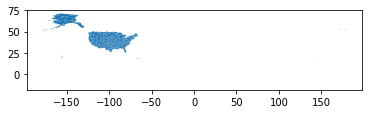

In [21]:
%matplotlib inline
polys.plot()

为了让循环少一点，这样应该会快一点，所以循环判断多边形。先取一个多边形做示例。

In [22]:
# Select data
alabama = polys.loc[polys['NAME']== 'Alabama']
# Check the selction
alabama.head()

,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
5,6,{150BD6A2-25CB-4B38-8719-1DA05AB084DA},None,None,None,None,2012-06-11,0,14561983.0,58930.31,AL,0315,Alabama,19.570968,5.695383,"POLYGON ((-84.83429 35.14971, -84.83400 35.149..."


In [23]:
# 重新设置下索引号，方便后面取值，直接用0比较方便
alabama.reset_index(drop=True, inplace=True)

alabama.head()

,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,6,{150BD6A2-25CB-4B38-8719-1DA05AB084DA},None,None,None,None,2012-06-11,0,14561983.0,58930.31,AL,0315,Alabama,19.570968,5.695383,"POLYGON ((-84.83429 35.14971, -84.83400 35.149..."


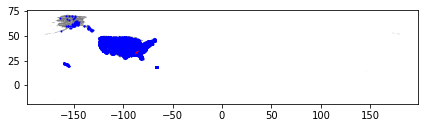

In [26]:
import matplotlib.pyplot as plt

# Create a figure with one subplot
fig, ax = plt.subplots()

# Plot polygons
polys.plot(ax=ax, facecolor='gray')

# Plot points
points.plot(ax=ax, color='blue', markersize=1)

alabama.plot(ax=ax, facecolor='red')

plt.tight_layout()

In [27]:
#import shapely.speedups
from shapely import speedups
speedups.enabled

# If false, run this line:
#shapely.speedups.enable()

True

In [28]:
pip_mask = points.within(alabama.at[0, 'geometry'])
print(pip_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
9317    False
9318    False
9319    False
9320    False
9321    False
Length: 9322, dtype: bool


In [29]:
pip_data = points.loc[pip_mask]
pip_data

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,FLYRS1900,FLYRS1950,FLYRS1990,geometry
2113,02379500,"CARTECAY RIVER NEAR ELLIJAY, GA.",Non-ref,EastHghlnds,347.7582,03,34.684252,-84.458538,GA,None,yes,40.0,28.0,0.0,POINT (-84.45854 34.68425)
2114,02380500,"COOSAWATTEE RIVER NEAR ELLIJAY, GA",Non-ref,EastHghlnds,611.6292,03,34.674975,-84.508554,GA,None,yes,57.0,46.0,20.0,POINT (-84.50855 34.67497)
2115,02381090,"MOUNTAINTOWN CREEK AT GA 282, NEAR ELLIJAY, GA",Non-ref,EastHghlnds,160.0200,03,34.703140,-84.539370,GA,None,yes,1.0,1.0,1.0,POINT (-84.53937 34.70314)
2116,02381600,"FAUSETT CREEK NEAR TALKING ROCK, GA",Ref,EastHghlnds,10.3248,03,34.570366,-84.468816,GA,yes,yes,35.0,35.0,20.0,POINT (-84.46882 34.57037)
2117,02382200,"TALKING ROCK CREEK NEAR HINTON, GA",Non-ref,EastHghlnds,309.8763,03,34.522778,-84.611111,GA,None,yes,35.0,35.0,20.0,POINT (-84.61111 34.52278)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2212,02425000,CAHABA RIVER NEAR MARION JUNCTION AL,Non-ref,SEPlains,4572.6210,03,32.444025,-87.180272,AL,None,yes,57.0,46.0,20.0,POINT (-87.18027 32.44402)
2213,02425500,"CEDAR CREEK AT MINTER, AL.",Ref,SEPlains,547.5933,03,32.079311,-86.983874,AL,None,None,26.0,26.0,0.0,POINT (-86.98387 32.07931)
2214,02427250,"PINE BARREN CREEK NEAR SNOW HILL, AL.",Ref,SEPlains,675.2439,03,31.996258,-87.068319,AL,yes,yes,20.0,20.0,20.0,POINT (-87.06832 31.99626)
2215,02427700,TURKEY CREEK AT KIMBROUGH AL,Ref,SEPlains,252.4770,03,32.020982,-87.558334,AL,None,None,38.0,38.0,7.0,POINT (-87.55833 32.02098)


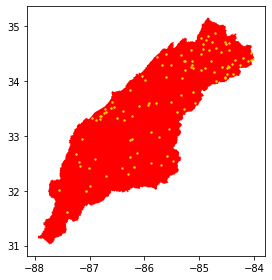

In [30]:
# Create a figure with one subplot
fig, ax = plt.subplots()

# Plot polygons
alabama.plot(ax=ax, facecolor='red')

# Plot points
pip_data.plot(ax=ax, color='gold', markersize=2)

plt.tight_layout()

再试一个multipolygon的

In [31]:
polys.head(11)

,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,{2836BE66-8D09-4A23-819A-032ACFC07EC9},None,None,None,None,2012-06-11,0,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."
1,2,{9F60218E-B1CA-4EAF-8931-CA52BDA34AB3},None,None,None,None,2012-06-11,0,65524952.0,265170.31,AK,1902,South Central Alaska,89.820883,43.854624,"MULTIPOLYGON (((-147.12113 63.62619, -147.1193..."
2,3,{385907E5-EED5-4B90-97A3-403EC8B96CF6},None,None,None,None,2012-06-11,0,81222880.0,328697.62,AK,1903,Southwest Alaska,154.283501,55.858380,"MULTIPOLYGON (((-152.03511 64.41507, -152.0325..."
3,4,{84E9AA98-74D8-49D9-BE79-A44C89A3EFCE},None,None,None,None,2012-06-11,0,50834280.0,205719.21,AK,1905,Northwest Alaska,71.800744,41.153359,"MULTIPOLYGON (((-166.16926 68.87117, -166.1683..."
4,5,{E510FB22-3CEC-4490-B6D4-1A2EF616217E},None,None,None,None,2012-06-11,0,59066087.0,239032.18,AK,1906,Arctic Alaska,74.176092,54.664269,"POLYGON ((-155.77282 71.28410, -155.77268 71.2..."
5,6,{150BD6A2-25CB-4B38-8719-1DA05AB084DA},None,None,None,None,2012-06-11,0,14561983.0,58930.31,AL,0315,Alabama,19.570968,5.695383,"POLYGON ((-84.83429 35.14971, -84.83400 35.149..."
6,7,{908918BB-D4D9-40F6-8DAD-066F047E091F},None,None,None,None,2012-06-11,0,9606724.0,38877.07,"AL,FL",0314,Choctawhatchee-Escambia,13.914481,3.654149,"POLYGON ((-85.71132 32.15153, -85.71127 32.151..."
7,8,{30512D2A-8937-4BB9-A61A-63AEA55EFD00},None,None,None,None,2012-06-11,0,13958983.0,56490.05,AL,0316,Mobile-Tombigbee,20.431950,5.460989,"POLYGON ((-88.39960 34.75187, -88.39939 34.751..."
8,9,{CE41D4D6-4611-4C30-A47D-D9BF5F612613},None,None,None,None,2012-06-11,0,6641059.0,26875.44,"AL,TN",0603,Middle Tennessee-Elk,11.559202,2.644846,"POLYGON ((-85.94717 35.47875, -85.94579 35.477..."
9,10,{D5704948-EFDE-45F7-A565-5BA43A63F64F},None,None,None,None,2012-06-11,0,10774741.0,43603.87,"AR,MS",0802,Lower Mississippi-St. Francis,19.330712,4.337474,"POLYGON ((-90.33322 37.84773, -90.33299 37.847..."


In [32]:
# Select data
Southeast_Alaska = polys.loc[polys['OBJECTID']== 1]
# Check the selction
Southeast_Alaska.head()

,OBJECTID,TNMID,METASOURCE,SOURCEDATA,SOURCEORIG,SOURCEFEAT,LOADDATE,GNIS_ID,AREAACRES,AREASQKM,STATES,HUC4,NAME,SHAPE_Leng,SHAPE_Area,geometry
0,1,{2836BE66-8D09-4A23-819A-032ACFC07EC9},None,None,None,None,2012-06-11,0,44545954.0,180271.24,AK,1901,Southeast Alaska,57.947896,28.870353,"MULTIPOLYGON (((-138.05906 61.25548, -138.0569..."


In [33]:
pip_mask = points.within(Southeast_Alaska.at[0, 'geometry'])
print(pip_mask)

0       False
1       False
2       False
3       False
4       False
        ...  
9317    False
9318    False
9319    False
9320    False
9321    False
Length: 9322, dtype: bool


In [34]:
pip_data = points.loc[pip_mask]
pip_data

,STAID,STANAME,CLASS,AGGECOREGI,DRAIN_SQKM,HUC02,LAT_GAGE,LNG_GAGE,STATE,HCDN_2009,ACTIVE09,FLYRS1900,FLYRS1950,FLYRS1990,geometry
9058,15012000,WINSTANLEY C NR KETCHIKAN AK,Ref,Alaska,39.964880,19,55.416051,-130.869197,AK,None,None,30.0,26.0,0.0,POINT (-130.86920 55.41605)
9059,15019990,TYEE LK OUTLET NR WRANGELL AK,Non-ref,Alaska,37.461620,19,56.199641,-131.508362,AK,None,yes,19.0,19.0,17.0,POINT (-131.50836 56.19964)
9060,15022000,HARDING R NR WRANGELL AK,Ref,Alaska,172.764800,19,56.212978,-131.638358,AK,None,None,52.0,52.0,14.0,POINT (-131.63836 56.21298)
9061,15026000,CASCADE C NR PETERSBURG AK,Non-ref,Alaska,59.634460,19,57.005496,-132.780883,AK,None,None,38.0,24.0,0.0,POINT (-132.78088 57.00550)
9062,15048000,SHEEP C NR JUNEAU AK,Ref,Alaska,11.023530,19,58.274673,-134.315655,AK,None,None,31.0,24.0,0.0,POINT (-134.31565 58.27467)
9063,15050000,GOLD C AT JUNEAU AK,Non-ref,Alaska,24.657370,19,58.306617,-134.403159,AK,None,None,48.0,42.0,9.0,POINT (-134.40316 58.30662)
9064,15051010,SALMON C NR JUNEAU AK,Non-ref,Alaska,25.112210,19,58.332174,-134.467607,AK,None,yes,19.0,19.0,19.0,POINT (-134.46761 58.33217)
9065,15052000,LEMON C NR JUNEAU AK,Ref,Alaska,31.986050,19,58.391343,-134.422606,AK,None,yes,28.0,28.0,7.0,POINT (-134.42261 58.39134)
9066,15055500,ANTLER R BL ANTLER LK NR AUKE BAY AK,Ref,Alaska,67.803780,19,58.851624,-134.710401,AK,None,yes,1.0,1.0,1.0,POINT (-134.71040 58.85162)
9067,15056210,TAIYA R NR SKAGWAY AK,Ref,Alaska,472.321400,19,59.511618,-135.346275,AK,None,yes,14.0,14.0,6.0,POINT (-135.34628 59.51162)


接下来就利用一波join来在point的shapefile里增加一列HUC04属性。